In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(428)

# Problem 1

In [2]:
df = pd.read_csv('ps2data.csv', index_col=0)

## Part 1
**There are not graduate students in our group**
## Part 2
Recall the MSE decomposition:
$$
\begin{align*}
MSE(\hat{f}\vert X^*) & = \mathbb{E}\left[\left(\hat{f}(X^*) - \mathbb{E}\left[\hat{f}(X^*)\right]\right)^2\bigg|X^*\right] + \left(\mathbb{E}\left[\hat{f}(X^*)\vert X^*\right] - \mathbf{f(X^*)}\right)^2  + \sigma^2\\
\end{align*}
$$
Notice that in the MSE decomposition we use the true function $f(x)$ to calculate the bias term. This is obviously not possible when $f(x)$ is unknown. 
## Part 3
### (A)

### (B)

## Part 4

In [3]:
def cross_validation_fn(
    data: pd.DataFrame,
    K: int,
    func: callable,
    **kwargs
) -> float:
    """
    Perform K-fold cross validation on the given data using the given function.
    """
    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    # Split the data into K folds
    folds = np.array_split(data, K)
    # Perform cross validation
    errors = []
    for i in range(K):
        # Create the training and testing sets
        test = folds[i]
        train = pd.concat([folds[j] for j in range(K) if j != i])
        # Perform the function
        error = func(train, test, **kwargs)
        errors.append(error)
    return np.mean(errors)

In [27]:
# Use our cross validation function to find the best degree polynomial
def choose_polynomial(data: pd.DataFrame, degree: int=30) -> float:
    error = []
    for i in range(1, degree+1):
        error.append(cross_validation_fn(
            df,
            15,
            lambda train, test, degree: np.mean((np.polyval(np.polyfit(train['x'], train['y'], degree), test['x']) - test['y'])**2),
            degree=i
        ))
    return error.index(min(error)) + 1

In [37]:
%%capture # Annoying rank warning for polyfit
best_degree = choose_polynomial(df)

In [38]:
print(f"The best degree polynomial is {best_degree}")

The best degree polynomial is 5


/Users/markviti/opt/anaconda3/envs/data/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/markviti/opt/anaconda3/envs/data/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


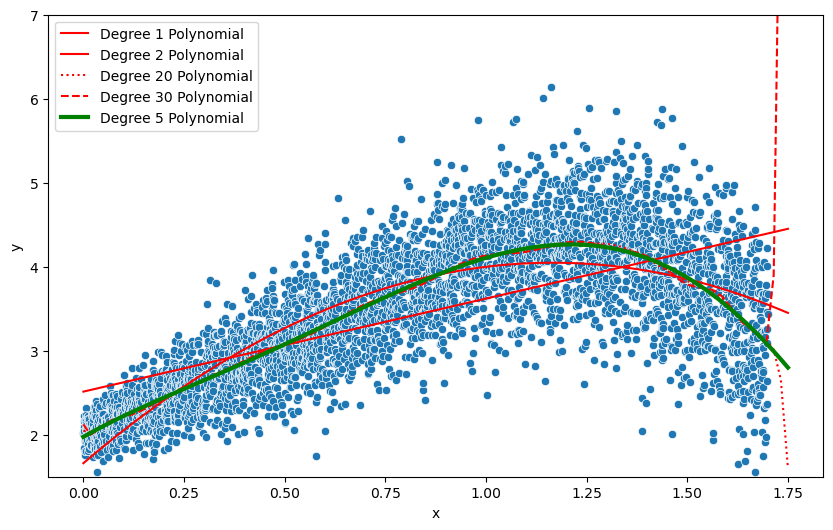

In [72]:
# Plot the best degree polynomial using sns, also including bad polynomials in red
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y')
x = np.linspace(0, 1.75, 100)
for i in [1, 2, 20, 30]:
    if i != best_degree:
        y = np.polyval(np.polyfit(df['x'], df['y'], i), x)
        plt.plot(x, y, label=f"Degree {i} Polynomial", color='red', linestyle = [['-', '-.', ':', '--'][i//10]][0])
y = np.polyval(np.polyfit(df['x'], df['y'], best_degree), x)
plt.plot(x, y, label=f"Degree {best_degree} Polynomial", color='green', linewidth=3)
plt.legend()
plt.ylim(1.5, 7)
plt.show()

## Part 5
In general there are two approaches: analytical and empirical. The analytical approach is to derive the bias-variance decomposition for the specific model and loss function. The empirical approach is to estimate the bias and variance by using the model to fit the data multiple times and then calculate the bias and variance from the fitted models. This would involve leaving out a subset of the data and using a validation set to estimate the bias and variance. Note that (in general) the analytical approach might not be possible if the model is too complex or the loss function is not known. The empirical approach is always possible, but it might be computationally expensive. 

I prefer the empirical approach because it is always possible and it is more general. It creates a more standard procedure that can always be used, allowing for greater reproducibility.

## Part 7

# Problem 2
**I have not seen expected optimism yet**

# Problem 3
## 1. 

In [60]:
def calc_ATE(data: pd.DataFrame) -> float:
    return data[data['treatment'] == 1]['Outcomes'].mean() - data[data['treatment'] == 0]['Outcomes'].mean()

def does_ATE_work(data: pd.DataFrame, err: float = 1e-1) -> bool:
    formula_ATE = calc_ATE(data)
    real_ATE = data[data['treatment'] != 0]['treatment'].mean() 
    print(f'Formula ATE: {formula_ATE}')
    print(f'Real ATE: {real_ATE}')
    return (abs(formula_ATE - real_ATE) < err, formula_ATE, real_ATE)

In [43]:
# Generating a random dataset such that outcomes are not well approximated by ATE
n = 1000
# Step 1: Create a dataset such that the outcome is not independent of the treatment
Y = np.random.binomial(1, 0.5, size=n)
treatment = [0 if y == 0 else 1 for y in Y]

data = pd.DataFrame({'Y': Y, 'treatment': treatment})
data['Outcomes'] = data['treatment'] + data['Y'] + np.random.normal(0, 0.1, n)

In [44]:
calc_ATE(data)
does_ATE_work(data)

Formula ATE: 1.9980062427524492
Real ATE: 1.0


(False, 1.9980062427524492, 1.0)

## 2.

In [95]:
Y_2 = np.random.binomial(1, 0.5, size=n)
treatment_2 = np.random.binomial(1, 0.5, size=n)

data_2 = pd.DataFrame({'Y': Y_2, 'treatment': treatment_2, 'Outcomes': Y_2 + treatment_2 + np.random.normal(0, 0.1, n)})
calc_ATE(data_2)
does_ATE_work(data_2)

Formula ATE: 0.9805256441738843
Real ATE: 1.0


(True, 0.9805256441738843, 1.0)